In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/CODING/kaggle/house Prices/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/CODING/kaggle/house Prices/test.csv')

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Okay what I want to do is get a baseline RMSE score on the train set then try some feature engineering to improve my baseline score

In [6]:
# save a copy of train_df for feature engineering
feature_train_df = train_df.copy(deep=True)

#Data Cleaning for train set pre feature engineering

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
train_df.duplicated().sum()

0

In [9]:
#Drop all columns that are missing a substantial portion of rows
# also drop id columns since not needed

In [10]:
train_df.drop(columns=['Alley','FireplaceQu','PoolQC','MiscFeature','Fence','Id'], inplace=True)

Will implement imputers in a pipeline to deal with the rest of the missing values that way i can use pre-processing the same way on the test set<br>
also did not drop test set columns yet waiting for the feature engenering set for best rmse

#Train data base scores

In [11]:
#pre processing pipeline
cat_select = make_column_selector(dtype_include='object')
num_select = make_column_selector(dtype_include='number')

scaler = StandardScaler()
encoder = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer()

num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, encoder)

pre_processor = make_column_transformer((num_pipe, num_select),(cat_pipe, cat_select))

In [12]:
# Train test split
X = train_df.drop(columns='SalePrice')
y = train_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [13]:
model_dic1 = { 'ridge': Ridge(),'xgb': XGBRegressor(objective='reg:squarederror'),
              'ran_forest': RandomForestRegressor(), 'bagging_reg': BaggingRegressor(), 'dec_tree': DecisionTreeRegressor()}

In [14]:
#function to take multiple models and print out metrics of them
def multi_model_eval(model_dic):
  new_df = pd.DataFrame.from_dict(model_dic, orient='index')
  new_df['Train_R2'] = 0
  new_df['Test_R2'] = 0
  new_df['Train_Rmse'] = 0
  new_df['Test_Rmse'] = 0
  new_df.drop(columns=0, inplace= True)
  for model in model_dic:
    model_pipe = make_pipeline(pre_processor, model_dic[model])
    model_pipe.fit(X_train, y_train)
    #Train Predictions
    train_pred = model_pipe.predict(X_train)
    mse_train = mean_squared_error(y_train, train_pred)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, train_pred)
    new_df.loc[model,'Train_Rmse'] = rmse_train
    new_df.loc[model,'Train_R2'] = r2_train
    #Test predictions
    test_pred = model_pipe.predict(X_test)
    mse_test = mean_squared_error(y_test, test_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, test_pred)
    new_df.loc[model,'Test_Rmse'] = rmse_test
    new_df.loc[model,'Test_R2'] = r2_test
  print(new_df)

In [15]:
multi_model_eval(model_dic1)

             Train_R2   Test_R2    Train_Rmse     Test_Rmse
ridge        0.917638  0.889633  22361.977112  27805.666508
xgb          0.966850  0.882345  14186.879666  28709.098158
ran_forest   0.978049  0.896068  11544.473081  26982.860347
bagging_reg  0.968389  0.880094  13853.707426  28982.373348
dec_tree     1.000000  0.800921      0.000000  37344.497359


#Data exploring for feature engineering

In [16]:
feature_train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [17]:
feature_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

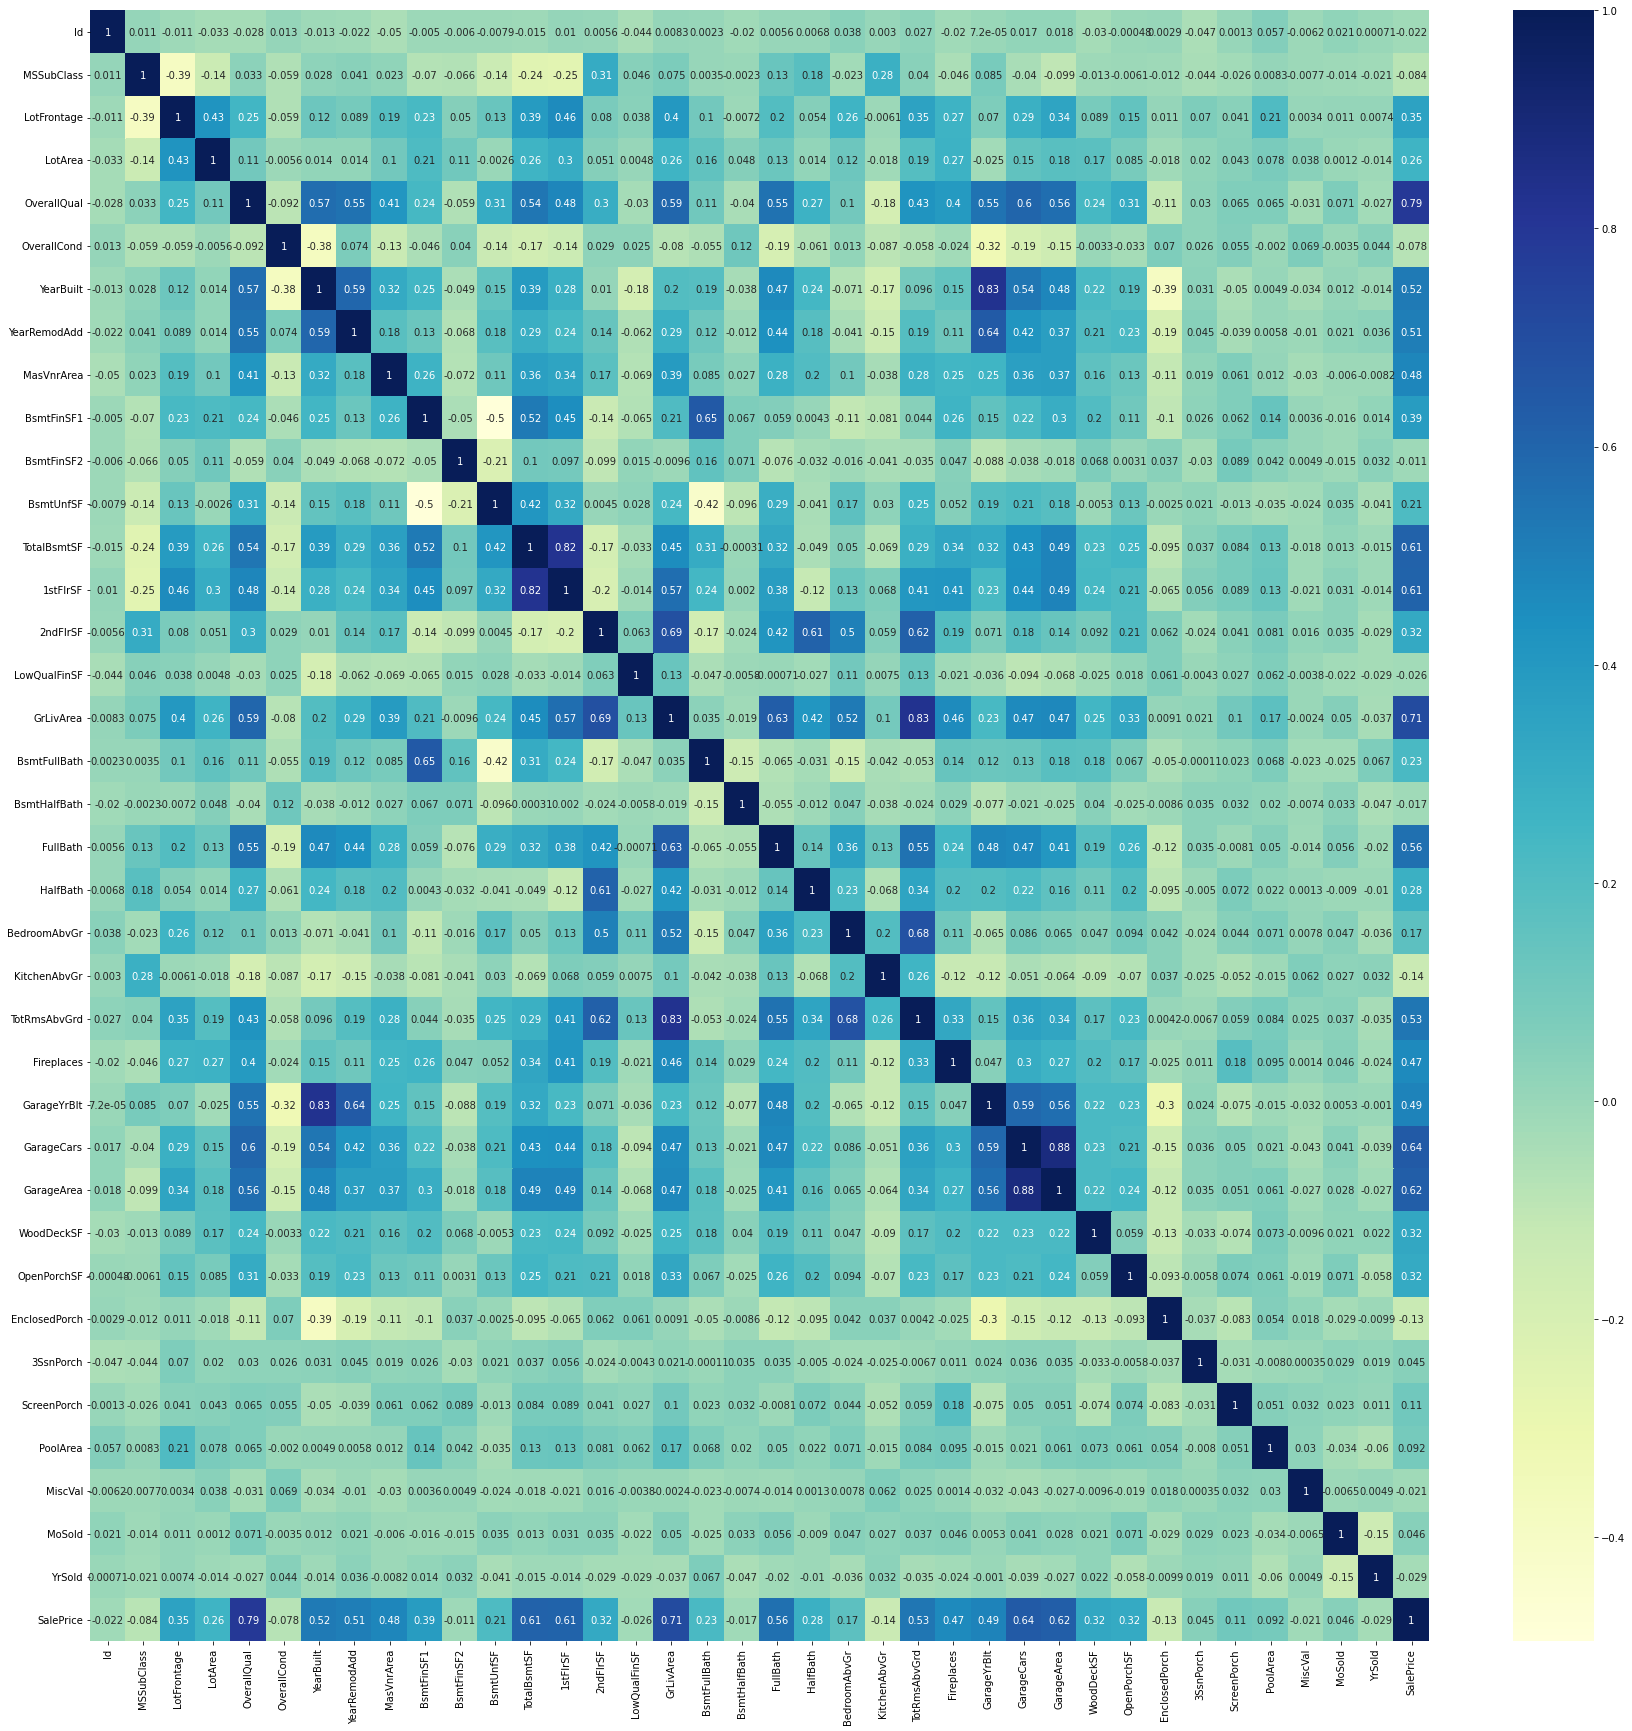

In [18]:
corr = feature_train_df.corr()
f, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(corr,cmap = 'YlGnBu', annot = True)

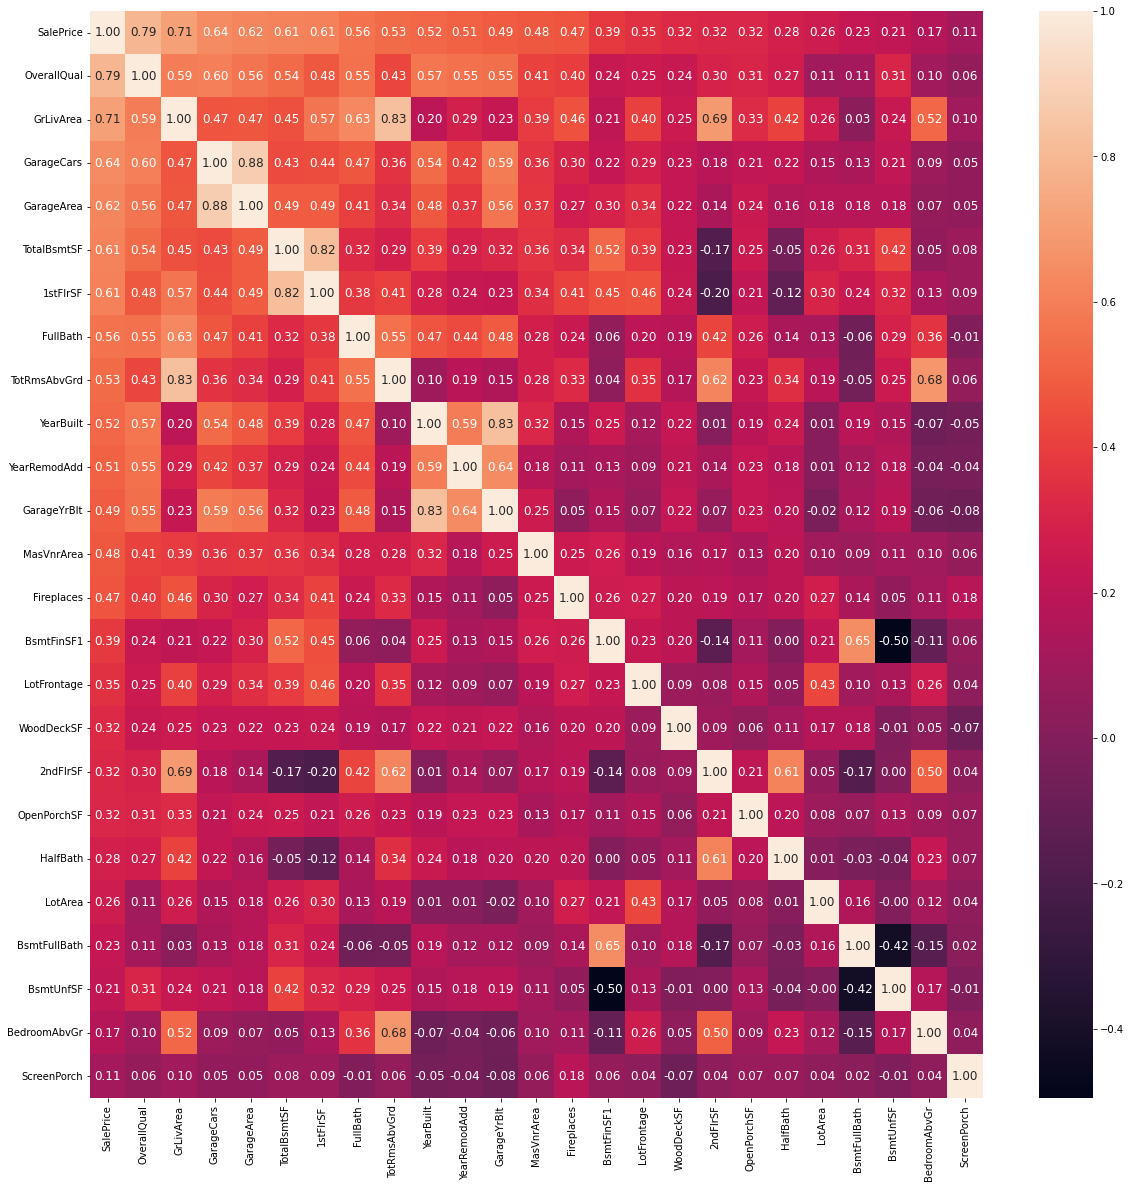

In [19]:
k = 25
#number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = feature_train_df[cols].corr()
f, ax = plt.subplots(figsize=(k*.8, k*.8))
sns.heatmap(cm, cbar=True, annot=True, fmt='.2f',annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)

In [20]:
#Going to use the top 24 highest correlated features for the model

In [21]:
feature_train_df = feature_train_df[cols]

In [22]:
feature_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SalePrice     1460 non-null   int64  
 1   OverallQual   1460 non-null   int64  
 2   GrLivArea     1460 non-null   int64  
 3   GarageCars    1460 non-null   int64  
 4   GarageArea    1460 non-null   int64  
 5   TotalBsmtSF   1460 non-null   int64  
 6   1stFlrSF      1460 non-null   int64  
 7   FullBath      1460 non-null   int64  
 8   TotRmsAbvGrd  1460 non-null   int64  
 9   YearBuilt     1460 non-null   int64  
 10  YearRemodAdd  1460 non-null   int64  
 11  GarageYrBlt   1379 non-null   float64
 12  MasVnrArea    1452 non-null   float64
 13  Fireplaces    1460 non-null   int64  
 14  BsmtFinSF1    1460 non-null   int64  
 15  LotFrontage   1201 non-null   float64
 16  WoodDeckSF    1460 non-null   int64  
 17  2ndFlrSF      1460 non-null   int64  
 18  OpenPorchSF   1460 non-null 

In [23]:
feature_train_df.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,...,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,HalfBath,LotArea,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,ScreenPorch
0,208500,7,1710,2,548,856,856,2,8,2003,...,65.0,0,854,61,1,8450,1,150,3,0
1,181500,6,1262,2,460,1262,1262,2,6,1976,...,80.0,298,0,0,0,9600,0,284,3,0
2,223500,7,1786,2,608,920,920,2,6,2001,...,68.0,0,866,42,1,11250,1,434,3,0
3,140000,7,1717,3,642,756,961,1,7,1915,...,60.0,0,756,35,0,9550,1,540,3,0
4,250000,8,2198,3,836,1145,1145,2,9,2000,...,84.0,192,1053,84,1,14260,1,490,4,0


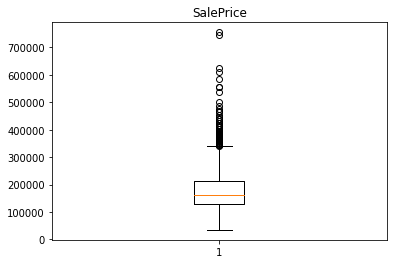

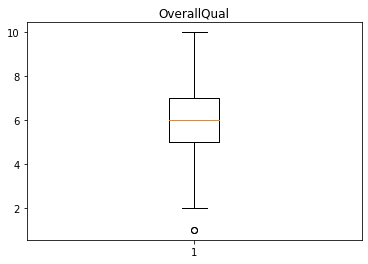

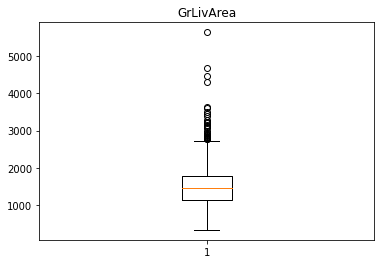

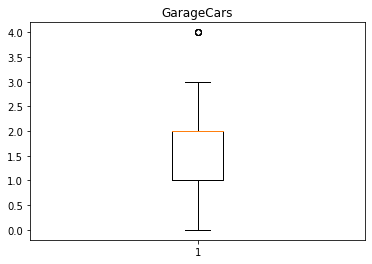

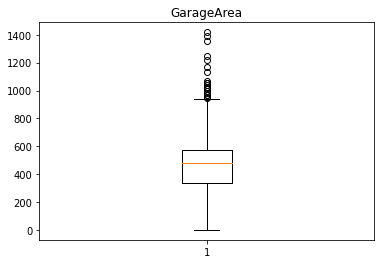

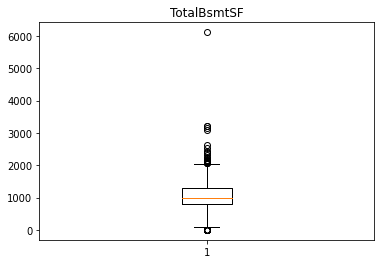

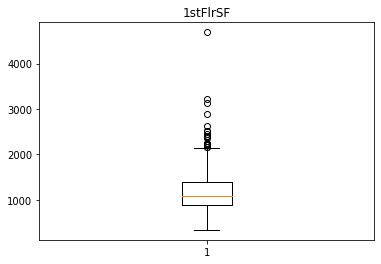

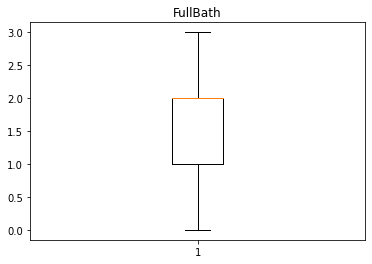

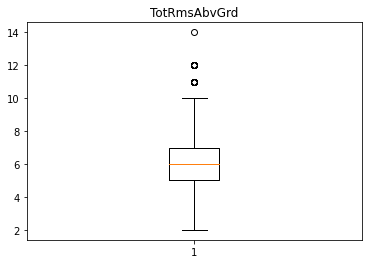

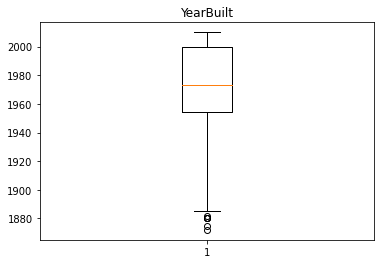

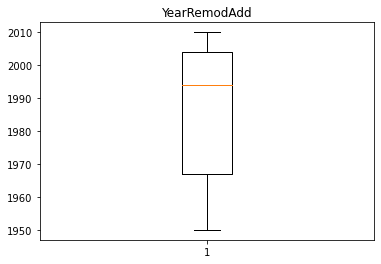

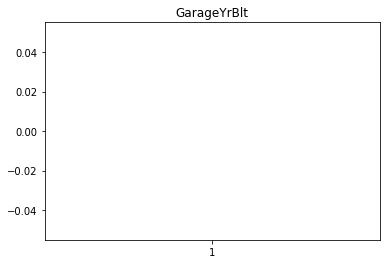

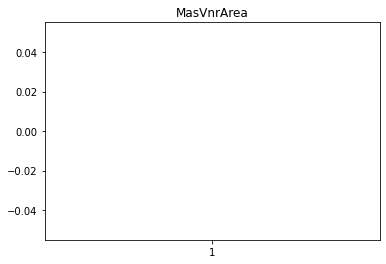

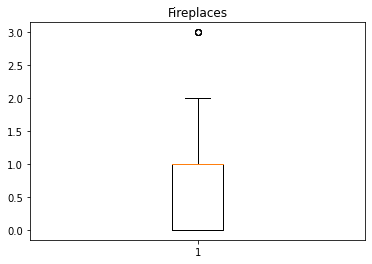

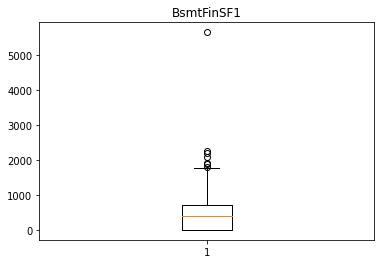

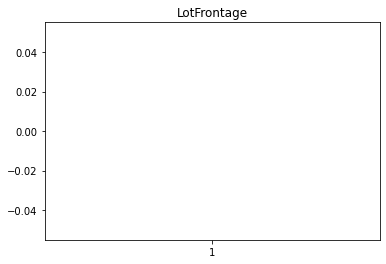

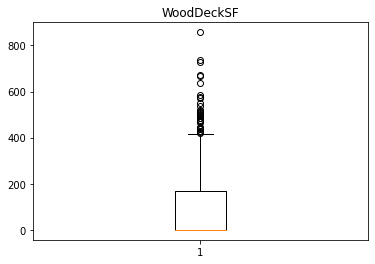

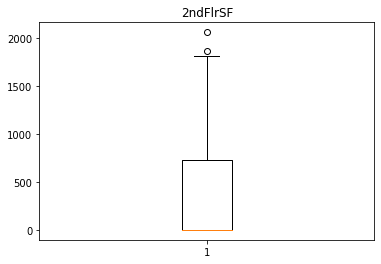

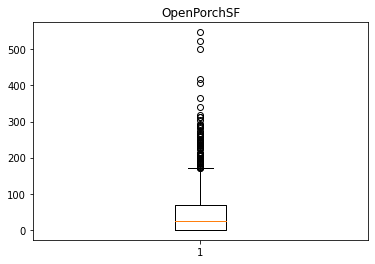

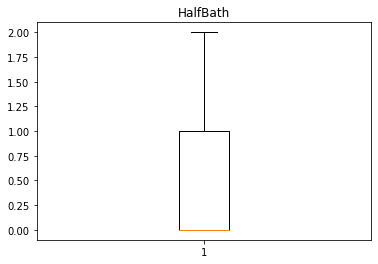

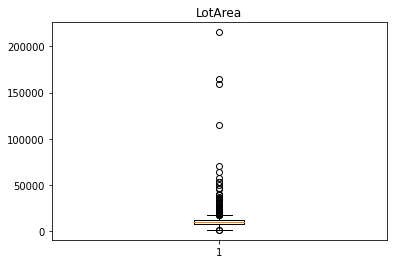

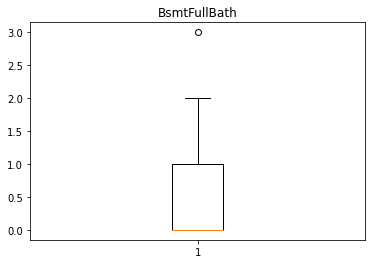

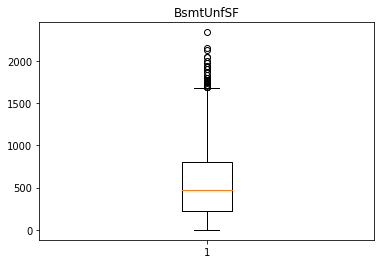

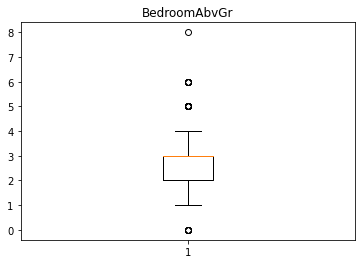

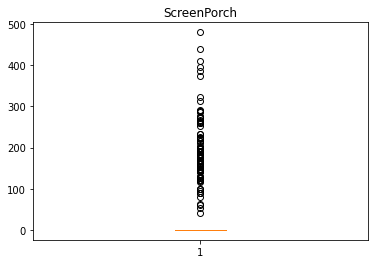

In [24]:
for col in feature_train_df:
  plt.boxplot(feature_train_df[col])
  plt.title(col)
  plt.show()

In [25]:
feature_train_df.groupby(['GarageCars'])['SalePrice'].count()

GarageCars
0     81
1    369
2    824
3    181
4      5
Name: SalePrice, dtype: int64

In [26]:
feature_train_df.groupby(['GarageCars'])['SalePrice'].mean()

GarageCars
0    103317.283951
1    128116.688347
2    183851.663835
3    309636.121547
4    192655.800000
Name: SalePrice, dtype: float64

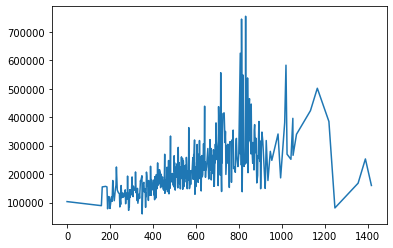

In [27]:
plt.plot(feature_train_df.groupby(['GarageArea'])['SalePrice'].mean())

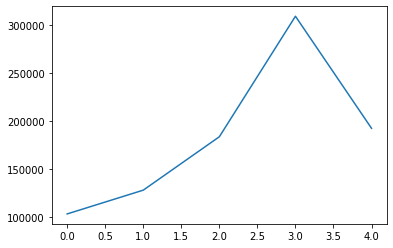

In [28]:
plt.plot(feature_train_df.groupby(['GarageCars'])['SalePrice'].mean())

In [29]:
#Okay I see that garagearea to saleprice mean shows positive correlation but I believe needs to be removed
#the 4 on garage cars the categoory should be 3+ because in some cases with new data 4 car garages will be more expensive than 2 or 3 in most cases

#Feature Changed Model!!

In [30]:
garage_four =  feature_train_df['GarageCars'] == 4

In [31]:
feature_train_df.loc[garage_four,'GarageCars'] = 3

In [32]:
# Changed all 4 car garages to 3 similating Kinda 3 + car agarage houses

In [33]:
feature_train_df.groupby(['GarageCars']).mean()

,SalePrice,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,...,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,HalfBath,LotArea,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,ScreenPorch
GarageCars,,,,,,,,,,,,,,,,,,,,,
0,103317.283951,4.604938,1188.148148,0.000000,767.728395,915.716049,1.308642,5.925926,1942.481481,1975.172840,...,60.405405,39.555556,237.481481,36.172840,0.160494,7469.679012,0.333333,507.234568,2.888889,0.000000
1,128116.688347,5.189702,1221.157182,300.517615,864.769648,968.821138,1.130081,5.845528,1948.243902,1971.257453,...,62.548077,65.479675,247.170732,23.449864,0.224932,8636.685637,0.327913,471.634146,2.785908,13.078591
2,183851.663835,6.251214,1552.553398,519.797330,1063.928398,1185.120146,1.686893,6.524272,1978.787621,1988.411408,...,70.624611,98.776699,363.520631,51.533981,0.445388,11076.458738,0.451456,545.502427,2.843447,17.461165
3,306491.489247,7.881720,2077.559140,813.693548,1537.010753,1554.989247,2.000000,8.080645,1996.166667,2000.376344,...,85.572254,155.048387,519.494624,75.682796,0.516129,13094.548387,0.543011,879.344086,3.118280,14.919355


In [34]:
garage_four =  test_df['GarageCars'] >= 4

In [35]:
test_df.loc[garage_four,'GarageCars'] = 3

In [36]:
cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1',
       'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath',
       'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'ScreenPorch'],
      dtype='object')

In [37]:
colList = cols.tolist()

In [44]:
#check if word is in list
def check(word, list):
    if word in list:
      print("word in list")  
    else:
      test_df.drop(columns=[col], inplace= True)

In [39]:
#drop all columns that arent in List
for col in test_df:
  if col != 'Id':
    check(col, colList)

word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list
word in list


In [40]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            1459 non-null   int64  
 1   LotFrontage   1232 non-null   float64
 2   LotArea       1459 non-null   int64  
 3   OverallQual   1459 non-null   int64  
 4   YearBuilt     1459 non-null   int64  
 5   YearRemodAdd  1459 non-null   int64  
 6   MasVnrArea    1444 non-null   float64
 7   BsmtFinSF1    1458 non-null   float64
 8   BsmtUnfSF     1458 non-null   float64
 9   TotalBsmtSF   1458 non-null   float64
 10  1stFlrSF      1459 non-null   int64  
 11  2ndFlrSF      1459 non-null   int64  
 12  GrLivArea     1459 non-null   int64  
 13  BsmtFullBath  1457 non-null   float64
 14  FullBath      1459 non-null   int64  
 15  HalfBath      1459 non-null   int64  
 16  BedroomAbvGr  1459 non-null   int64  
 17  TotRmsAbvGrd  1459 non-null   int64  
 18  Fireplaces    1459 non-null 

In [41]:
#feature_train_df.drop(columns=['GarageArea'], inplace = True)
#test_df.drop(columns=['GarageArea'], inplace = True)

In [42]:
X = feature_train_df.drop(columns=['SalePrice'])
y = feature_train_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [46]:
multi_model_eval(model_dic1)

             Train_R2   Test_R2    Train_Rmse     Test_Rmse
ridge        0.788876  0.819298  35802.640046  35579.160888
xgb          0.954624  0.902242  16598.184921  26169.205562
ran_forest   0.976726  0.891911  11887.204689  27517.259481
bagging_reg  0.958677  0.864861  15839.455906  30768.289822
dec_tree     0.999991  0.833036    229.934579  34199.961201


In [47]:
#Some improvements Some worse But 90 percent on testing baseline on XGB Regressor is nice! Going to tune that one and use

In [49]:
tune_pipe = make_pipeline(pre_processor, XGBRegressor())

In [57]:
tune_pipe.fit(X_train, y_train);

[21:02:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [71]:
tune_pipe.get_params();

In [59]:
grid_param = {'xgbregressor__learning_rate':[0.01,0.05,0.1,0.2,0.5,1],'xgbregressor__max_depth':[1,3,10,15,20,50,100,200],'xgbregressor__n_estimators':[10,50,100,200,400,600,800,1000,1500,2000]}

In [61]:
grid = RandomizedSearchCV(tune_pipe,grid_param, random_state= 42, cv = 10, n_jobs=-1)

search = grid.fit(X_train,y_train);

[21:09:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [62]:
print(search.best_params_)
print("TrainScore:",search.score(X_train,y_train))
print("TestScore:",search.score(X_test,y_test))

{'xgbregressor__n_estimators': 100, 'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.1}
TrainScore: 0.9546236955558511
TestScore: 0.9022416691907704


In [63]:
grid_param = {'xgbregressor__learning_rate':[0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15],'xgbregressor__max_depth':[2,3,4,5,6,7,8,9],'xgbregressor__n_estimators':[80,85,90,95,100,105,110,115,120,125]}

In [64]:
grid = GridSearchCV(tune_pipe,grid_param,n_jobs=-1)

search = grid.fit(X_train,y_train);

[21:21:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [66]:
def eval_model(true, pred):
  mse = mean_squared_error(true, pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(true, pred)

  print(f'RMSE: {rmse},\n R^2: {r2} ')

In [67]:
print(search.best_params_)
print('Train Evaluation')
eval_model(y_train, search.predict(X_train))
print('\nTest Evaluation')
eval_model(y_test, search.predict(X_test))

{'xgbregressor__learning_rate': 0.07, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 80}
Train Evaluation
RMSE: 18779.854021362487,
 R^2: 0.9419112073855899 

Test Evaluation
RMSE: 26996.70571067661,
 R^2: 0.8959614609743021 


In [68]:
preds = search.predict(test_df)

In [69]:
to_submit = pd.DataFrame({'Id': test_df['Id'],'SalePrice':preds})
to_submit.head()

,Id,SalePrice
0,1461,123572.765625
1,1462,152243.562500
2,1463,175292.875000
3,1464,184041.750000
4,1465,215275.515625


In [70]:
to_submit.to_csv('/content/drive/MyDrive/CODING/kaggle/house Prices/submissions.csv',index = False)